# Practical Session 3
## Kernel Methods for Machine Learning

Written by Yunlong Jiao, Romain Menegaux 20 May 2020

In [ ]:
# setup
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
import sys
print(sys.version)

In [ ]:
import sklearn
sklearn.__version__

In [ ]:
import sys
try:
    !conda install --yes --prefix {sys.prefix} cvxopt
    solver = 'cvxopt'
except:
    try:
        !conda install --yes --prefix {sys.prefix} -c omnia quadprog
        # !pip install quadprog
        solver = 'quadprog'
    except:
        solver = None
        
if solver == 'quadprog':
    import quadprog
    print('Using quadprog')
elif solver == 'cvxopt':
    import cvxopt
    print('Using cvxopt')
else:
    print('No QP solver installed')

## Part 1
- **Generate 20 binary classification samples** (10 from each class $y = 1$ and $y = −1$).
$$$$
Use $\mathbf{x} \in \mathbb{R}^2$, for visualization purpose, where each element $x \sim \mathcal{N}(\mu_y,\sigma^2), \mu_1 = 0, \mu_{-1}=1$.
$$$$
- **Generate 1000 separate testing samples from the same distribution**
- **Visualize training data.**
$$$$

In [5]:
# Simulate data
np.random.seed(54321)
p = 2

def generate_Xy(n_samples, p=2, sigma=.2):

    return X, y

# Training data
X_train, y_train = generate_Xy(20)

# Testing data
X_test, y_test = generate_Xy(1000)

In [6]:
# Prediction error
def error(y_pred, y_true):
    e = (y_pred != y_true).mean()
    return e

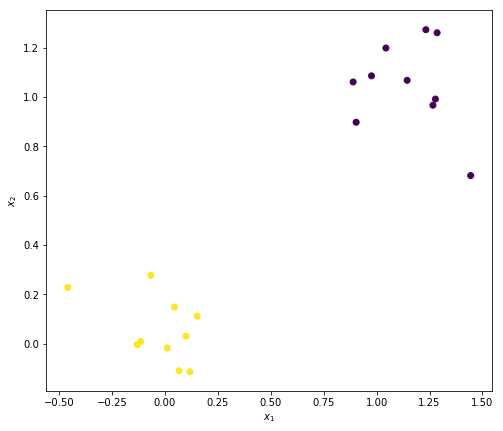

In [7]:
# Visualize training data

def plot_data(X, y):
    plt.figure(figsize=(8,7))

    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.show()
    
plot_data(X_train, y_train)

In [ ]:
plot_data(X_test, y_test)

## Question 2
**Train a linear SVM** with parameter $C = 10$ on the training set, using the function `sklearn.svm.LinearSVC`. Inspect the resulting object

In [9]:
# Parameters
C = 10

# Training
clf = 'implement your classifier'

In [ ]:
# Training error
y_fit = clf.predict(X_train)
err_train = error(y_fit, y_train)
print('Training error = {:.1%}'.format(err_train))

# Testing error
y_pred = clf.predict(X_test)
err_test = error(y_pred, y_test)
print('Testing error = {:.1%}'.format(err_test))

***
### Plot the points and the decision boundaries of a linear SVM.
Recall: 
the boundary (separating hyperplane) is the set of points for which $f(x) = 0$.

In [ ]:
def plot_points_with_margin(X, y, w, b):# Visualize training data and separating hyperplane
    plt.figure(figsize=(8,7))

    # Training data
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

    # Separating hyperplane and decision boundaries
    x1 = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    x2 = 0
    x2_up = 0
    x2_low = 0

    plt.plot(x1, x2, 'b')
    plt.plot(x1, x2_up, 'b--')
    plt.plot(x1, x2_low, 'b--')

    # Plot
    plt.show()
    
w = clf.coef_[0]
b = clf.intercept_[0]
plot_points_with_margin(X_train, y_train, w, b)

***
## Part 2
We will use a quadratic program (QP) solver `cvxopt` to find our own solution to SVM

```
cvxopt.solvers.qp(P, q[, G, h[, A, b]])
```
solves the quadratic program

$$
\begin{aligned}
\min_x & \, \frac{1}{2}x^\top P x + q^\top x \\
\mathrm{s.t. } \, & Gx \leq h \\
& Ax = b
\end{aligned}
$$

- $P, q$ define the objective
- $G, h$ are all the inequality constraints
- $A, b$ are all the equality constraints

**Find $P$, $q$, $G$, $h$, $A$ and $b$ for the hard margin SVM**
***

First step: what is $x$ in our case, with the slides notations?

**Hard margin:** (slide 83)
- Primal $x = $
- Dual $x = $

**Soft margin:** (slides 89, 91)
- Primal $x = $
- Dual $x = $

***
We set $X_y = \mathrm{diag}(y)X = (y_1x_1, ..., y_nx_n)^\top \in \mathbb{R}^{n\times p}$

$X_y$ is simply $X$ with its rows $i$ multiplied by $y_i$

### Hard margin SVM

**Primal**
$$
\begin{aligned}
\min_{w, b} & \, \frac{1}{2}w^\top w \\
\mathrm{s.t. } \, & y_i x_i^\top w + y_i b \geq 1\\
\end{aligned}
$$

<font color='red'> Watch out for the signs in the constraints! </font>

**Dual:**
$$
\begin{aligned}
\max_\alpha & \, \mathrm{1}^\top\alpha - \frac{1}{2}\alpha^\top X_y X_y^\top \alpha \\
\mathrm{s.t. } \, & \alpha \geq 0 \\
& y^\top\alpha = 0
\\
\end{aligned}
$$

### Let's implement it!

In [ ]:
# You don't need to look at this, this is just to adapt our matrices
# to the solver being used

def quadprog_solve_qp(P, q, G=None, h=None, A=None, b=None):
    qp_G = .5 * (P + P.T)   # make sure P is symmetric
    qp_a = -q
    if A is not None:
        qp_C = -np.vstack([A, G]).T
        qp_b = -np.hstack([b, h])
        meq = A.shape[0]
    else:  # no equality constraint
        qp_C = - G.T
        qp_b = - h
        meq = 0
    return quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0]

def cvxopt_qp(P, q, G, h, A, b):
    P = .5 * (P + P.T)
    cvx_matrices = [
        cvxopt.matrix(M) if M is not None else None for M in [P, q, G, h, A, b] 
    ]
    solution = cvxopt.solvers.qp(*cvx_matrices)
    return np.array(solution['x']).flatten()

solve_qp = {'quadprog': quadprog_solve_qp, 'cvxopt': cvxopt_qp}[solver]

In [ ]:
def svm_primal_hard_to_qp(X, y):
    n, p = X.shape
    assert (len(y) == n)
    
    Xy = np.diag(y).dot(X)
    # Primal formulation, hard margin
    diag_P = np.zeros(p+1) # correct this!
    # As a regularization, we add epsilon * identity to P
    eps = 1e-12
    diag_P += eps
    P = np.diag(diag_P)

    return P, q, G, h, A, b

coefs = solve_qp(*svm_primal_hard_to_qp(X_train, y_train))
n, p = X_train.shape
w, b = 0, 0 #FIXME

In [ ]:
plot_points_with_margin(X_train, y_train, w, b)

In [ ]:
def svm_dual_hard_to_qp(X, y):
    n, p = X.shape
    assert (len(y) == n)
    
    Xy = np.diag(y).dot(X)
    # Dual formulation, hard margin
    
    # As a regularization, we add epsilon * identity to P
    eps = 1e-12
    P += eps * np.eye(n)

    return P, q, G, h, A, b

alphas = solve_qp(*svm_dual_soft_to_qp(X_train, y_train))

**Soft margin SVM, primal:**
$$
\begin{aligned}
\min_{w, b, \xi} & \, \frac{1}{2}w^\top w + C \mathbf{1}^\top \xi \\
\mathrm{s.t. } \, & \xi \geq 0 \\
& y_i x_i^\top w + y_i b + \xi_i\geq 1
\\
\end{aligned}
$$

- <font color='green'> $P = \frac{1}{2}I_p$ with 0 padding to make it $(p+1+n) \times (p+1+n)$
- $q = (0,..., 0, C, ..., C)$ </font> $q$ is $0$ $(p+1)$ times then $C$ $n$ times
$$$$
- <font color='green'> $G = -\left[X_y^\top, y, I_n\right]^\top, h = -\mathbf{1}_n^\top$</font>
- <font color='green'> $A = 0, b = 0$ </font>

**Soft margin SVM, dual:**
$$
\begin{aligned}
\max_\alpha & \, \mathrm{1}^\top\alpha -\frac{1}{2}\alpha^\top X_y^T X_y \alpha \\
\mathrm{s.t. } \, & \alpha \geq 0 \\
& \alpha \leq C \\
& y^\top\alpha = 0
\\
\end{aligned}
$$

- <font color='green'> $P = -X_y^T X_y$, $q = -\mathbf{1}$ </font>
- <font color='green'> $G = [-I, I]^\top, h = (0, ..., 0, C, ..., C)^\top$</font> $h$ is $0$ $n$ times then $C$ $n$ times
$$$$
- <font color='green'> $A = y^\top, b = 0$ </font>

In [ ]:
def svm_dual_soft_to_qp(X, y, C=1):
    n, p = X.shape
    assert (len(y) == n)
    
    Xy = np.diag(y).dot(X)
    # Dual formulation, soft margin
    P = 0.5 * Xy.dot(Xy.T)
    # As a regularization, we add epsilon * identity to P
    eps = 1e-12
    P += eps * np.eye(n)
    q = - np.ones(n)
    G = np.vstack([-np.eye(n), np.eye(n)])
    h = np.hstack([np.zeros(n), C * np.ones(n)])
    A = y[np.newaxis, :]
    b = np.array([0.])
    return P, q, G, h, A, b

C = 10
alphas = solve_qp(*svm_dual_soft_to_qp(X_train, y_train, C=C))


In [ ]:
def svm_primal_soft_to_qp(X, y, C=1):
    n, p = X.shape
    assert (len(y) == n)
    
    Xy = np.diag(y).dot(X)
    # Primal formulation, soft margin
    diag_P = np.hstack([0.5 * np.ones(p), np.zeros(n + 1)])
    # As a regularization, we add epsilon * identity to P
    eps = 1e-12
    diag_P += eps
    P = np.diag(diag_P)
    
    q = np.hstack([np.zeros(p + 1), C * np.ones(n)])
    # y(wx+b)+ei>=1
    G1 = - np.hstack([Xy, y[:, np.newaxis], np.eye(n)])
    # ei>=0
    G2 = - np.hstack([np.zeros((n, p+1)), np.eye(n)])
    G = np.vstack([G1, G2])
    h = - np.hstack([np.ones(n), np.zeros(n)])
    A = None
    b = None
    return P, q, G, h, A, b

coefs = solve_qp(*svm_primal_soft_to_qp(X_train, y_train, C=C))
n, p = X_train.shape
w, b, e = coefs[:p], coefs[p], coefs[(p+1):]


In [ ]:
plot_points_with_margin(X_test, y_test, w, b)

## Part 4
- Try different values of $C$, and visualize the effect of $C$ on the margin and number of support vectors.
$$$$
- Train a linear SVM with values of $C$ between $10^{−3}$ and $1$. Plot and analyze the training and testing classification errors as a function of $C$. Question: Why can't we overfit more?
$$$$
- Choose $C$ by cross-validation.

In [ ]:
from sklearn.model_selection import cross_val_score

# Cross validation
CL = 10 ** np.linspace(-3, 2, 100)
cvsL = np.zeros(len(CL))

for i,C in enumerate(CL):
    clf = sklearn.svm.LinearSVC(penalty='l2',loss='hinge',C=C)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    cvsL[i] = scores.mean()

In [ ]:
import bqplot.pyplot as bqp
from ipywidgets import IntSlider, HTML, HBox

slider_C = IntSlider(min=0, max=len(CL)-1, value=len(CL)/2, readout=False)
readout = HTML()
fig = bqp.figure(min_aspect_ratio=1.1, max_aspect_ratio=1.1,
           layout={'min_width': '500px', 'min_height': '500px'})
scat = bqp.scatter(X_test[::10, 0], X_test[::10, 1],
                   colors=['orange' if y == 1 else 'purple' for y in y_test[::10]])
                   #axes_options={'color': None})
sep = bqp.plot(x1, np.zeros_like(x1), preserve_domain={'x': True, 'y': True})
margin_up = bqp.plot(x1, np.zeros_like(x1), '--', preserve_domain={'x': True, 'y': True})
margin_down = bqp.plot(x1, np.zeros_like(x1), '--', preserve_domain={'x': True, 'y': True})

def compute_margins(w0, w1, w2, x1):
    x2 = (-w0 - w1 * x1) / w2
    x2_up = (-w0 - w1 * x1 - 1) / w2
    x2_low = (-w0 - w1 * x1 + 1) / w2
    
    return x2, x2_up, x2_low

def update_margins(*args):
    i = slider_C.value
    sep.y, margin_up.y, margin_down.y = compute_margins(w0[i], w[i, 0], w[i, 1], sep.x)
    readout.value = 'C = {:.3f}'.format(CL[i])

slider_C.observe(update_margins)
update_margins()

#bqp.show()
VBox([fig, HBox([slider_C, readout])])